In [1]:
!pip install transformers datasets sacrebleu evaluate accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"  # Disable Weights & Biases logging

from datasets import load_dataset
from evaluate import load as load_metric
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)
import numpy as np
import nltk
nltk.download("punkt")

# Step 1: Load dataset
raw_dataset = load_dataset("bmd1905/error-correction-vi")

# Optional: create validation split
split_dataset = raw_dataset["train"].train_test_split(test_size=0.05, seed=42)
dataset = {
    "train": split_dataset["train"],
    "validation": split_dataset["test"]
}

# Step 2: Load model and tokenizer
model_name = "vinai/bartpho-syllable"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vi_processed.csv:   0%|          | 0.00/131M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/359993 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

dict.txt:   0%|          | 0.00/360k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

In [4]:
# Step 3: Preprocess dataset
max_input_length = 256
max_target_length = 256

def preprocess_function(examples):
    inputs = examples["error_text"]
    targets = examples["correct_text"]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=max_target_length, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

encoded_dataset = {
    split: dataset[split].map(preprocess_function, batched=True)
    for split in ["train", "validation"]
}

Map:   0%|          | 0/341993 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

In [5]:
# Step 4: Metric
metric = load_metric("sacrebleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

# Step 5: Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./bartpho-correction",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=100,
    report_to=None,  # Disable wandb
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Step 6: Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Step 7: Train
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-5-6593ca4a1ec0>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Bleu
1,0.024000,0.018824,31.934284


TrainOutput(global_step=10688, training_loss=0.08400620114125178, metrics={'train_runtime': 10741.0776, 'train_samples_per_second': 31.84, 'train_steps_per_second': 0.995, 'total_flos': 1.852858026814341e+17, 'train_loss': 0.08400620114125178, 'epoch': 1.0})

In [6]:
# Step 8: Save model locally
trainer.save_model("./bartpho-correction-model")
tokenizer.save_pretrained("./bartpho-correction-model")

In [7]:
# Step 9: Backup to Google Drive
!cp -r ./bartpho-correction-model /content/drive/MyDrive/

In [25]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

checkpoint = "/content/drive/MyDrive/bartpho-correction-model"

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/bartpho-correction-model")

input_text = "Sau đó bài hátđược nhiều người biết kđến yơn với sự thể hiện",
  # Example wrong sentence
inputs = tokenizer(input_text, return_tensors="pt")

outputs = model.generate(**inputs)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Sau đó bài hát được nhiều người biết đến hơn với sự thể hiện.


In [17]:
# 1. Load required libraries
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from evaluate import load as load_metric
import matplotlib.pyplot as plt
import numpy as np

# 2. Load 1% of the dataset
ds = load_dataset("bmd1905/vi-error-correction-v2", split="train[:1%]")

# 3. Load model and tokenizer from checkpoint
model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/bartpho-correction-model")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/bartpho-correction-model")


train.csv:  68%|######7   | 83.9M/124M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/7.32M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/339993 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20000 [00:00<?, ? examples/s]

BLEU score: 90.65


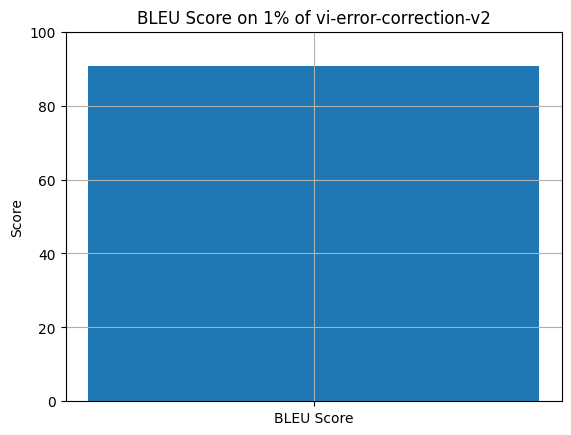

In [21]:
# 4. Metric setup
metric = load_metric("sacrebleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

# 5. Prepare input and reference texts
inputs = ds["input"]
references = ds["output"]

# 6. Run inference in batches (with max_length=256)
batch_size = 32
predictions = []

for i in range(0, len(inputs), batch_size):
    batch_inputs = inputs[i:i+batch_size]
    tokenized = tokenizer(batch_inputs, return_tensors="pt", padding=True, truncation=True, max_length=256)
    output_ids = model.generate(**tokenized, max_new_tokens=256)
    decoded = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    predictions.extend(decoded)

# 7. Compute BLEU score
preds, refs = postprocess_text(predictions, references)
result = metric.compute(predictions=preds, references=refs)

print(f"BLEU score: {result['score']:.2f}")

# 8. Plot BLEU score
plt.bar(["BLEU Score"], [result["score"]])
plt.ylim(0, 100)
plt.title("BLEU Score on 1% of vi-error-correction-v2")
plt.ylabel("Score")
plt.grid(True)
plt.show()

In [28]:
from datasets import load_dataset
import torch
from torch.nn import CrossEntropyLoss

# Load 1% of the dataset
ds = load_dataset("bmd1905/vi-error-correction-v2", split="train[:1%]")
ds = ds.shuffle(seed=42).select(range(100))

# Load metric
from evaluate import load as load_metric
metric = load_metric("sacrebleu")

# Postprocessing
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

inputs = ds["input"]
references = ds["output"]

batch_size = 32
predictions = []
total_loss = 0
total_tokens = 0

loss_fct = CrossEntropyLoss(ignore_index=-100)  # -100 tells it to ignore padding

for i in range(0, len(inputs), batch_size):
    batch_inputs = inputs[i:i+batch_size]
    batch_refs = references[i:i+batch_size]

    # Tokenize inputs and targets
    tokenized_inputs = tokenizer(batch_inputs, padding=True, truncation=True, max_length=256, return_tensors="pt")
    tokenized_targets = tokenizer(text_target=batch_refs, padding=True, truncation=True, max_length=256, return_tensors="pt")

    input_ids = tokenized_inputs["input_ids"].to(model.device)
    attention_mask = tokenized_inputs["attention_mask"].to(model.device)
    labels = tokenized_targets["input_ids"].to(model.device)

    # Mask out padding tokens in the labels
    labels[labels == tokenizer.pad_token_id] = -100

    # Forward pass with labels
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss

    # Accumulate total loss and token count
    total_loss += loss.item() * (labels != -100).sum().item()
    total_tokens += (labels != -100).sum().item()

    # Generate predictions
    generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=256)
    decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    predictions.extend(decoded_preds)

# Compute BLEU
preds, refs = postprocess_text(predictions, references)
bleu_result = metric.compute(predictions=preds, references=refs)
avg_loss = total_loss / total_tokens

print(f"BLEU score (first 100 sentences): {bleu_result['score']:.2f}")
print(f"Cross-Entropy Loss (token-level): {avg_loss:.4f}")


BLEU score (first 100 sentences): 91.33
Cross-Entropy Loss (token-level): 0.1210
